#### Load the libraries

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
import gensim
import numpy as np
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary


### Connect to drive to get the data

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# df_news = pd.read_csv("/content/gdrive/My Drive/text_summarization/df_news_20minutos.csv")
# df_news.head(2)

In [6]:
df_news = pd.read_csv('positivos (1).csv')#, encoding='utf-8')
# transcripciones = df["transcripcion_limpia"]

In [3]:
# df2 = pd.read_csv('data_clean_desde_indice_1078_hasta_el_final_csv.csv')

In [5]:
# df2.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
       'Unnamed: 0.1.1.1.1', 'Unnamed: 0.1.1.1.1.1', 'level_0', 'index',
       'Unnamed: 0.1.1.1.1.1.1', 'ID_MOPC', 'IDMOROSO', 'IDCLIENTE',
       'OPERADOR', 'CAMPA��', 'IDGRABACION', 'TIPO_DISCADOR', 'FECHA', 'ID',
       'IDLLAMADA', 'ESTADO', 'SUBESTADO', 'F_INICIO', 'ANI_TELEFONO',
       'GRABACION_DEP', 'TIPO', 'CRM', 'BASE', 'LOG', 'DIRECCION',
       'IDOPERADOR', 'AGENDAMIENTO_ESTADO', 'anos', 'mes',
       'transcripcion_limpia', 'transcripcion', 'Contestador', 'Valido'],
      dtype='object')

In [10]:
# df2.dropna(inplace=True)

In [20]:
# df2.rename(columns = {'CAMPA��':'CAMPAÑA'}, inplace = True)

In [3]:
df_news.columns

Index(['Unnamed: 0', 'level_0', 'index', 'ID_MOPC', 'IDMOROSO', 'IDCLIENTE',
       'OPERADOR', 'CAMPAÑA', 'IDGRABACION', 'TIPO_DISCADOR', 'FECHA', 'ID',
       'IDLLAMADA', 'ESTADO', 'SUBESTADO', 'F_INICIO', 'ANI_TELEFONO',
       'GRABACION_DEP', 'TIPO', 'CRM', 'BASE', 'LOG', 'DIRECCION',
       'IDOPERADOR', 'AGENDAMIENTO_ESTADO', 'anos', 'mes',
       'transcripcion_limpia', 'Contestador', 'transcripcion', 'Valida',
       'turnos_tokenizados', 'turnos_filtrados', 'turnos_lematizados',
       'longitud_turnos', 'frases', 'sentimiento'],
      dtype='object')

In [4]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            238 non-null    int64  
 1   level_0               238 non-null    int64  
 2   index                 238 non-null    int64  
 3   ID_MOPC               238 non-null    float64
 4   IDMOROSO              238 non-null    object 
 5   IDCLIENTE             238 non-null    object 
 6   OPERADOR              238 non-null    float64
 7   CAMPAÑA               238 non-null    float64
 8   IDGRABACION           238 non-null    object 
 9   TIPO_DISCADOR         238 non-null    object 
 10  FECHA                 238 non-null    object 
 11  ID                    238 non-null    object 
 12  IDLLAMADA             238 non-null    float64
 13  ESTADO                238 non-null    object 
 14  SUBESTADO             238 non-null    object 
 15  F_INICIO              2

In [5]:
# df2.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1','Unnamed: 0.1.1.1.1', 'Unnamed: 0.1.1.1.1.1', 'level_0', 'index','Unnamed: 0.1.1.1.1.1.1'], inplace=True, axis=1)
# df_news.dropna(inplace=True)
# df_news.shape

(202, 37)

In [5]:
df_news.head()

,Unnamed: 0,index,ID_MOPC,IDMOROSO,IDCLIENTE,OPERADOR,CAMPAÑA,IDGRABACION,TIPO_DISCADOR,FECHA,...,transcripcion_limpia,Contestador,transcripcion,Valida,turnos_tokenizados,turnos_filtrados,turnos_lematizados,longitud_turnos,frases,sentimiento
0,0,0,242789.0,DNI 17446006,HSBC_LEGALES14,1893.0,13.0,0296415532961-58516182-20210412080350.mp3,Manual,2021-04-12,...,m ibs ...,0.0,"[00:00.000 --> 00:05.000] Hola, disculpe. Hab...",0.0,"['m', 'ibs', 'mm', 'mibs', 'mm', 'mibs', 'mm',...","['m', 'ibs', 'mm', 'mibs', 'mm', 'mibs', 'mm',...","['m', 'ibs', 'mm', 'mib', 'mm', 'mib', 'mm', '...",310,"['m', 'ibs', 'mm', 'mibs', 'mm', 'mibs', 'mm',...",negativo
1,1,1,242828.0,DNI 22833374,BSR_TARDIA,1736.0,75.0,0341152104531-58516255-20210412083146.mp3,Manual,2021-04-12,...,si si que tal buen dia alejandra si ...,0.0,"['[00:00.000 --> 00:01.000] Hola.', '[00:01.0...",0.0,"['si', 'si', 'que', 'tal', 'buen', 'dia', 'ale...","['buen', 'alejandra', 'alejandra', 'maria', 'c...","['buen', 'alejandra', 'alejandra', 'maria', 'c...",229,"['si', 'si que tal buen dia alejandra', 'si', ...",negativo
2,2,2,252660.0,DNI 14103422,BSR_TARDIA,3358.0,75.0,0352115465488-58539435-20210412145237.mp3,Manual,2021-04-12,...,que tal buen dia se encuentra si si c...,0.0,"['[00:00.000 --> 00:05.000] Hola. Hola, ¿qué ...",0.0,"['que', 'tal', 'buen', 'dia', 'se', 'encuentra...","['buen', 'encuentra', 'gisi', 'ivana', 'ivana'...","['buen', 'encuentra', 'gisi', 'ivana', 'ivana'...",363,"['que tal buen dia se encuentra', 'si', 'si co...",negativo
5,5,7,243240.0,DNI 28016261,FRANCES_2012,2070.0,30.0,0223155790018-58517842-20210412091748.mp3,Manual,2021-04-12,...,si maria me escucha este corton si le escu...,0.0,"['[00:00.000 --> 00:03.000] Sí, María, ¿me es...",0.0,"['si', 'maria', 'me', 'escucha', 'este', 'cort...","['maria', 'escucha', 'corton', 'escucho', 'esc...","['maria', 'escucha', 'corton', 'escucho', 'esc...",112,"['si maria me escucha este corton', 'si le esc...",negativo
6,6,8,243243.0,CUIT30708487151,BSR_TARDIA,1736.0,75.0,1558401818-58517849-20210412091753.mp3,Manual,2021-04-12,...,buen dia ariel si que tal ariel marial...,0.0,"['[00:00.000 --> 00:05.000] Hola. Hola, buen ...",0.0,"['buen', 'dia', 'ariel', 'si', 'que', 'tal', '...","['buen', 'ariel', 'ariel', 'marial', 'carmele'...","['buen', 'ariel', 'ariel', 'marial', 'carmele'...",49,"['buen dia ariel', 'si', 'que tal ariel marial...",negativo


#Data Preprocessing

We defined a list of custom words to be exclude from our dataset

In [7]:
black_list = ['si',
 'bueno',
 'banco',
 'usted',
 'tardes',
 'buenas',
#  'pago',
#  'deuda',
 'bien',
 'mas',
 'dias',
 'hacer',
 'senor',
 'ver',
 'puedo',
#  'cuotas',
 'va',
 'gracias',
 'perfecto',
 'puede',
 'ahora',
 'voy',
 'dia',
 'entonces',
 'buenos',
 'claro',
 'numero',
 'senora',
 'ah',
 'ok',
 'asi',
 'tal',
 'ahi',
 'favor',
 'manana',
 'luego',
 'estudio',
#  'pagar',
 'dale',
 'mes',
 'plan',
 'hablar',
 'agencia',
 'hola',
 'cómo',
 'ahí',
 'así',
 'día',
 'como',
 'ahi',
 'asi',
 'dia']

Create the cleaner function to clean the spanish text, remove non alpha numeric characters, remove duplicate, remove spanish accutes, remove digits

In [8]:
def cleaner(word):
  word = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', '', word, flags=re.MULTILINE)
  word = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', "", word)
  word = re.sub(r'ee.uu', 'eeuu', word)
  word = re.sub(r'\#\.', '', word)
  word = re.sub(r'\n', '', word)
  word = re.sub(r',', '', word)
  word = re.sub(r'\-', ' ', word)
  word = re.sub(r'\.{3}', ' ', word)
  word = re.sub(r'a{2,}', 'a', word)
  word = re.sub(r'é{2,}', 'é', word)
  word = re.sub(r'i{2,}', 'i', word)
  word = re.sub(r'ja{2,}', 'ja', word) 
  word = re.sub(r'á', 'a', word)
  word = re.sub(r'é', 'e', word)
  word = re.sub(r'í', 'i', word)
  word = re.sub(r'ó', 'o', word)
  word = re.sub(r'ú', 'u', word)  
  word = re.sub('[^a-zA-Z]', ' ', word)
  list_word_clean = []
  for w1 in word.split(" "):
    if  w1.lower() not in stopwords:
      list_word_clean.append(w1.lower())

  bigram_list = bigram[list_word_clean]
  out_text = lemmatization(" ".join(bigram_list))
  return out_text

Create the function for select **only nouns** for our data, this way we are removing adverb, adjetives, verbs, etc. This is doing with spacy

In [9]:
def lemmatization(texts, allowed_postags=['NOUN']):
    texts_out = [ token.text for token in nlp(texts) if token.pos_ in 
                 allowed_postags and token.text not in black_list and len(token.text)>2]
    return texts_out

For gensim we need a list of text, so we need do convert the dataframe to list

In [10]:
len(df_news.transcripcion.to_list())

238

Then we look for bigram in our data, i.e pair of words that together have more meanful for our model

In [11]:
%%time
bigram = gensim.models.Phrases(df_news.transcripcion.to_list()) 

CPU times: user 725 ms, sys: 1.79 ms, total: 727 ms
Wall time: 732 ms


Let's examine some output

In [12]:
bigram[df_news.transcripcion.to_list()]

/usr/local/lib/python3.8/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


["['[00:00.000 --> 00:10.560]  Hola, disculpe, hablo con la señora Erika Geraldini. Si les saludo, Iván Gabañas, del', '[00:10.560 --> 00:15.760]  estudio jurídico MOPC en representación al Banco Santander, ¿cómo está todo ello?', '[00:15.760 --> 00:24.520]  Sí, me comunico, referente a un saldo pendiente de 3.400 pesos, lo que yo lo ofrezco sería', '[00:24.520 --> 00:31.240]  un descuento del 60% para que usted pueda cancelar por el monto de 1.500. ¿Hay alguna', '[00:31.240 --> 00:35.200]  posibilidad que pueda cancelar por ese monto, Erika?', '[00:35.200 --> 00:40.040]  La verdad es que soy sin trabajo en este momento.', '[00:40.040 --> 00:47.800]  Entiendo, son 12 días de mora. ¿Cuándo usted calcula que va a poder pagar, Erika?', '[00:47.800 --> 00:53.160]  Y ahora que no, no faré decirte, pero como digo, soy sin trabajo, no únicamente que', '[00:53.160 --> 01:00.760]  confíe a alguien que me pueda pagar dinero, pero tendría que ver.', '[01:00.760 --> 01:07.560]  De igual manera, te

In [13]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [14]:
from nltk import word_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('spanish'))

additional_stopwords=set(black_list)

stopwords = stop.union(additional_stopwords)

We are using Spacy For lemmatize spanish words

In [15]:
!python -m spacy download es_dep_news_trf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.2/410.2 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 84.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 117.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_dep_news_trf')


In [16]:
import spacy
nlp = spacy.load('es_dep_news_trf')

Now let's test the cleaner function:

In [17]:
df_news.transcripcion[2]

"['[00:00.000 --> 00:24.400]  Hola, hola, hola, si disculpe hablo con la señora Claudia Miriam García, si les', '[00:24.400 --> 00:29.600]  lo digo en Gabañas del Estudio Curídico de MOPC, representación al Banco Santander', '[00:29.600 --> 00:39.160]  de Contadodía. Si nos comunicamos por un saldo pendiente de 58 mil pesos, lo que yo', '[00:39.160 --> 00:46.200]  lo ofrezco, señora Claudia, sería un descuento del 60%, con eso el saldo quedaría en 23', '[00:46.200 --> 00:51.800]  mil 18 pesos. ¿Hay alguna posibilidad de que usted pueda cancelar por ese mundo, Claudia?', '[00:51.800 --> 00:57.000]  No, por el momento no, no puedo. ¿Y en qué momento va a poder, porque son los', '[00:57.000 --> 01:02.480]  345 días de mora, Claudia? Bueno, no puedo, no puedo, no puedo.', '[01:02.480 --> 01:08.520]  ¿Y cuándo va a tener? No tengo. ¿Hay alguna posibilidad que podamos fraccionar este', '[01:08.520 --> 01:18.600]  mundo, por lo menos en 5 o 6 cuotas? Podría ser, pero no sé, pero me voy a ver 

In [18]:
cleaner(df_news.transcripcion[2])


/usr/local/lib/python3.8/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['saldo',
 'pesos',
 'descuento',
 'saldo',
 'pesos',
 'posibilidad',
 'momento',
 'momento',
 'posibilidad',
 'mundo',
 'cuotas',
 'caso',
 'cuotas',
 'cuotas',
 'posibilidad',
 'momento',
 'caso',
 'cuotas',
 'momento',
 'caso',
 'posibilidad',
 'propuesta']

The Cleaner function work properly

##### Let's clean all the text

In [19]:
df_news['transcripcion2'] = df_news['transcripcion']

In [20]:
%%time
df_news['transcripcion'] = df_news['transcripcion'].apply(cleaner)

CPU times: user 2min 21s, sys: 301 ms, total: 2min 21s
Wall time: 2min 28s


Now we need to build the *corpus* and the *dictionary* that gensim need to work, to do that we need to pass a list of list of tokens

In [21]:
dictionary = Dictionary(df_news['transcripcion'].to_list())
dictionary.compactify()
# Filter extremes
dictionary.filter_extremes(no_below=2, no_above=0.97, keep_n=None)
dictionary.compactify()

corpus = [dictionary.doc2bow(text) for text in df_news['transcripcion'].to_list()]

# Now let's do the modeling part

We are comparing 3 topic modeling algorithm Latent Dirichlet Allocation (LDA), Latent
semantic analysis (LSA), Hierarchical Dirichlet Process
(HDP),in order to evaluate topic models we will be using **topic coherence**, which is a measure of how
interpretable topics are for human beings.

 ## Hierarchical Dirichlet process Model

In [22]:
import time
time.clock = time.time

In [23]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary, random_state= 30)

and the topics of this model:

In [24]:
def display_topics(model, model_type="lda"):
  for topic_idx, topic in enumerate(model.print_topics()):
    print ("Topic %d:" % (topic_idx))
    if model_type== "hdp":
      print (" ".join(re.findall( r'\*(.[^\*-S]+).?', topic[1])), "\n")
    else:
      print (" ".join(re.findall( r'\"(.[^"]+).?', topic[1])), "\n")
    



In [25]:
hdpmodel.show_topics() 

display_topics(hdpmodel, model_type="hdp") 

Topic 0:
validez  enero  julio  vez  valor  novedad  telefonico  agenda  segundos  fotito 

Topic 1:
transcurso  totalidad  deuda  error  turno  escrito  promedio  diciembre  listo  mayo 

Topic 2:
depositos  expectativas  encargada  noche  comunicado  opinion  propuestas  pagos  mitad  hora 

Topic 3:
cuestion  enero  caso  enviadora  llamas  deudas  dependencia  ejemplo  tarjetas  interes 

Topic 4:
cajero  salida  agenda  marzo  acreditacion  gasto  negociacion  pase  mensajito  propuesta 

Topic 5:
contactos  realidad  personas  cuotas  vale  interes  tipo  saludos  instrucciones  minuto 

Topic 6:
horario  semana  planes  dato  pedido  forma  propuestas  promedio  marzo  esposo 

Topic 7:
planes  principios  changas  politicas  amigo  puerta  cuentas  esposo  ora  cuota 

Topic 8:
cuenta  paso  tipo  abogados  solicito  resumen  principios  opcion  brevedad  sucursal 

Topic 9:
fecha  horas  posibilidad  informacion  mediacion  resumenes  cobro  titular  comprobantes  turno 

Topi

as we could see there are 20 topics, however is kind of dificult to interpret or follow, so we decide to move to another model.





In [26]:
def evaluate_graph(dictionary, corpus, texts, limit, model):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        if model == 'lsi':
          lm = LsiModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        else:
          lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

##LSI MODEL

In [27]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [28]:
display_topics(lsimodel)  # Showing the topics

Topic 0:
deuda pago cuotas caso pesos acuerdo cuenta datos tarjeta semana 

Topic 1:
deuda pago semana verdad tarjeta acuerdo lunes cosa cuotas saldo 

Topic 2:
tarjeta cuotas caso contacto pesos datos deuda cuenta reclamo informacion 

Topic 3:
tarjeta cuotas caso pago contacto deuda bonificacion transferencia tema semana 

Topic 4:
cuotas semana saldo tarjeta bonificacion cuenta verdad turno acuerdo lunes 

Topic 5:
tarjeta datos pago verdad cuenta acuerdo caso cosas tema cuotas 

Topic 6:
pesos caso descuento tarjeta turno saldo datos verdad idea lunes 

Topic 7:
pago semana contacto saldo turno informacion telefono reclamo transferencia correo 

Topic 8:
cuenta verdad tarjeta saldo transferencia mensaje acuerdo pesos realidad bonificacion 

Topic 9:
telefono descuento pesos pagos bonificacion mensaje persona marzo correo opcion 



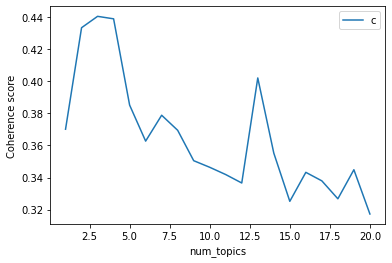

CPU times: user 9.12 s, sys: 3.03 s, total: 12.1 s
Wall time: 9.07 s


In [29]:
%%time
lmlist_lsi, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=df_news['transcripcion'].to_list(), limit=21, model= "lsi")

According to the coherence the best number of topics are between 3-7, however you must select the topics using both the coherence and visual inspection.


In [30]:
display_topics(lmlist_lsi[2])

Topic 0:
deuda pago cuotas caso pesos acuerdo cuenta datos tarjeta semana 

Topic 1:
deuda pago semana verdad tarjeta acuerdo lunes cosa cuotas saldo 

Topic 2:
tarjeta cuotas caso contacto pesos datos deuda cuenta reclamo informacion 



Now, Let's try another model

## Latent Dirichlet Allocation Model

In [31]:
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [32]:

display_topics(ldamodel)

Topic 0:
deuda cuotas vez contacto pesos opciones verdad cuenta problema pago 

Topic 1:
pago deuda saldo caso cuotas acuerdo pesos momento lunes descuento 

Topic 2:
pago deuda descuento caso semana informacion cuotas lunes acuerdo datos 

Topic 3:
pago cuota tarjeta semana martes cuenta mayo cuotas lunes telefono 

Topic 4:
pago deuda cuotas tarjeta datos pesos problema viernes fecha saldo 

Topic 5:
deuda turno pago lunes problema semana caso vez tarjeta persona 

Topic 6:
pago deuda cuotas acuerdo semana propuesta verdad cuenta datos nombre 

Topic 7:
pago cuenta semana deuda tema dinero pesos lunes fecha problema 

Topic 8:
pago deuda verdad pesos telefono semana tarjeta nombre cuenta momento 

Topic 9:
momento viernes julio pago telefono trabajo cuenta forma caso situacion 



Find out the optimal number of topics for the LDA model based on the coherence metric:

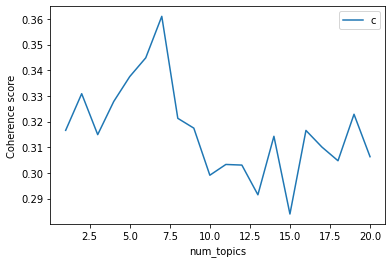

CPU times: user 11.3 s, sys: 664 ms, total: 12 s
Wall time: 11.3 s


In [33]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=df_news['transcripcion'].to_list(), limit=21, model= "lda")

### Comparing the Model Coherence of the Best Models

we made 3 models, now let's compare each other's  coherence

In [34]:

ldamodel = lmlist[11]
lsimodel = lmlist_lsi[2]

lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]

ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

In [35]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=df_news['transcripcion'].to_list(), dictionary=dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=df_news['transcripcion'].to_list(), dictionary=dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=df_news['transcripcion'].to_list(), dictionary=dictionary, window_size=10).get_coherence()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


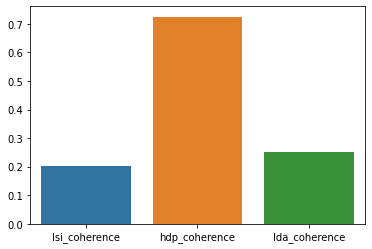

In [36]:
import seaborn as sns

coherences = [lsi_coherence, hdp_coherence, lda_coherence]
n = len(coherences)
x = ['lsi_coherence', 'hdp_coherence','lda_coherence']
sns.barplot(x, coherences)


Examine the keyword to get the topics of the best model

In [37]:
display_topics(hdpmodel, model_type="hdp") 

Topic 0:
validez  enero  julio  vez  valor  novedad  telefonico  agenda  segundos  fotito 

Topic 1:
transcurso  totalidad  deuda  error  turno  escrito  promedio  diciembre  listo  mayo 

Topic 2:
depositos  expectativas  encargada  noche  comunicado  opinion  propuestas  pagos  mitad  hora 

Topic 3:
cuestion  enero  caso  enviadora  llamas  deudas  dependencia  ejemplo  tarjetas  interes 

Topic 4:
cajero  salida  agenda  marzo  acreditacion  gasto  negociacion  pase  mensajito  propuesta 

Topic 5:
contactos  realidad  personas  cuotas  vale  interes  tipo  saludos  instrucciones  minuto 

Topic 6:
horario  semana  planes  dato  pedido  forma  propuestas  promedio  marzo  esposo 

Topic 7:
planes  principios  changas  politicas  amigo  puerta  cuentas  esposo  ora  cuota 

Topic 8:
cuenta  paso  tipo  abogados  solicito  resumen  principios  opcion  brevedad  sucursal 

Topic 9:
fecha  horas  posibilidad  informacion  mediacion  resumenes  cobro  titular  comprobantes  turno 

Topi

In [38]:
# ldamodel_16 =lmlist[16]


In [39]:
# display_topics(ldamodel_16)

# Classifiying all documents

now that we have been select the best model and topics number, is time to assign a topic to each document, means **cluster** according to the topics

In [78]:
def format_topics_sentences(hdpmodel=0, corpus=corpus, texts=0):
    # Init output
    sent_topics_df = pd.DataFrame()-n

    # Get main topic in each document
    for i, row in enumerate(hdpmodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = hdpmodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(hdpmodel, corpus=corpus, texts=df_news['transcripcion'].to_list())



In [79]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,91.0,0.4750,"mente, registro, caso, saldo, domingo, financi...","[saldo, descuento, monto, posibilidad, monto, ..."
1,1,27.0,0.8356,"informe, periodo, total, metodo, referencia, e...","[nombre, datos, encargo, deposito, pago]"
2,2,91.0,0.5790,"mente, registro, caso, saldo, domingo, financi...","[saldo, pesos, descuento, saldo, pesos, posibi..."
3,3,12.0,0.3858,"validez, forma, casos, predisposicion, arreglo...","[manias, nombre, representante, motivo, motivo..."
4,4,115.0,0.3557,"bonificacion, acreditacion, contacto, pago, su...","[bonificacion, saldo, facilidad, situacion, se..."
5,5,18.0,0.6379,"abono, mensajes, resumenes, acuerdos, pago, av...","[deuda, informacion, vez, cuotas, datos, cuota..."
6,6,127.0,0.2639,"demas, changas, cuotas, situacion, instancia, ...","[minutos, informacion, minutos, robo, mando, d..."
7,7,4.0,0.4964,"cajero, salida, agenda, marzo, acreditacion, g...","[mujer, obras, turno, verdad, propuesta, perio..."
8,8,102.0,0.6127,"miercoles, hora, cargo, cama, pais, pico, pago...","[foto, factura, sitio, pago, consulta, pago, t..."
9,9,26.0,0.3630,"manera, tranquilidad, momentos, cuestion, empr...","[saldo, suerte, saldo, saldo, pesos, descuento..."


In [42]:
df_dominant_topic.to_csv('df_dominant_topic.csv')

In [74]:
len(df_dominant_topic)

237

In [43]:
# from google.colab import files
# files.download('/content/df_dominant_topic.csv')

In [80]:
def most_common(lst):
    return max(set(lst), key=lst.count)

We selected the ldamodel with 12 topics and asigned a dominant topic to each document, now let map each topic with a label 

first let's create the dictionary

In [45]:
# df_dominant_topic.dropna(inplace=True)

In [81]:
most_common(df_dominant_topic.Keywords.to_list())

'propuestas, cuotas, problemas, puerta, instrucciones, panorama, efectivo, contacto, sistema, opinion, predisposicion, tarjeta, poder, transcurso, veces, junio, correo, servicios, metapor, agenda'

In [82]:
from collections import Counter
data = Counter(df_dominant_topic.Keywords.to_list())
data.most_common(20)

[('propuestas, cuotas, problemas, puerta, instrucciones, panorama, efectivo, contacto, sistema, opinion, predisposicion, tarjeta, poder, transcurso, veces, junio, correo, servicios, metapor, agenda',
  14),
 ('abono, mensajes, resumenes, acuerdos, pago, aviso, cantidad, noche, chica, trato, calculo, punto, video, abogada, cuotas, llamada, situacion, vez, atraso, cajero',
  12),
 ('caso, hora, comento, rato, instrucciones, acreditacion, intereses, ceritos, pago, semana, enero, prorroga, llamadas, intencion, datos, acciones, rocio, chofer, posibilidad, paga',
  10),
 ('mente, registro, caso, saldo, domingo, financiacion, descuento, saco, energia, rocio, bonificacion, meses, miercoles, dependencia, llamadas, acuerdos, casa, cobro, valor, telefono',
  8),
 ('demonia, sucursales, situacion, hermano, semana, efectivo, pago, dato, pais, concepto, titular, disculpas, abogado, momentos, abono, salud, pesos, cuota, lado, tarde',
  8),
 ('bonificacion, acreditacion, contacto, pago, sucursal, inic

In [83]:
label_dicc = {0:'pago', 1:'pesos', 2:'trabajo', 3: 'propuesta', 4:'tarjeta', 5:'acuerdo', 6:'saldo', 
              7:'opciones', 8:'cobranza', 9: 'problema', 10:'oferta', 11:'telefono'}

In [49]:
len(df_dominant_topic['Dominant_Topic'])

238

In [84]:
df_dominant_topic.dropna(inplace=True)

In [51]:
len(df_dominant_topic['Dominant_Topic'])

237

In [85]:
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].astype('int64')


In [86]:
df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].map(label_dicc)
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,NaN,0.4750,"mente, registro, caso, saldo, domingo, financi...","[saldo, descuento, monto, posibilidad, monto, ..."
1,1,NaN,0.8356,"informe, periodo, total, metodo, referencia, e...","[nombre, datos, encargo, deposito, pago]"
2,2,NaN,0.5790,"mente, registro, caso, saldo, domingo, financi...","[saldo, pesos, descuento, saldo, pesos, posibi..."
3,3,NaN,0.3858,"validez, forma, casos, predisposicion, arreglo...","[manias, nombre, representante, motivo, motivo..."
4,4,NaN,0.3557,"bonificacion, acreditacion, contacto, pago, su...","[bonificacion, saldo, facilidad, situacion, se..."
5,5,NaN,0.6379,"abono, mensajes, resumenes, acuerdos, pago, av...","[deuda, informacion, vez, cuotas, datos, cuota..."
6,6,NaN,0.2639,"demas, changas, cuotas, situacion, instancia, ...","[minutos, informacion, minutos, robo, mando, d..."
7,7,tarjeta,0.4964,"cajero, salida, agenda, marzo, acreditacion, g...","[mujer, obras, turno, verdad, propuesta, perio..."
8,8,NaN,0.6127,"miercoles, hora, cargo, cama, pais, pico, pago...","[foto, factura, sitio, pago, consulta, pago, t..."
9,9,NaN,0.3630,"manera, tranquilidad, momentos, cuestion, empr...","[saldo, suerte, saldo, saldo, pesos, descuento..."


In [54]:
# df_dominant_topic = pd.read_csv('df_dominant_topic (1).csv')

In [87]:
df_news['labels'] = df_dominant_topic['Dominant_Topic']


Let's examine some text and its topics

In [88]:
df_news[['transcripcion2', 'labels']].head(10)

,transcripcion2,labels
0,"['[00:00.000 --> 00:10.560] Hola, disculpe, h...",NaN
1,"['[00:00.000 --> 00:02.000] Hola, buenas tard...",NaN
2,"['[00:00.000 --> 00:24.400] Hola, hola, hola,...",NaN
3,"['[00:00.000 --> 00:10.160] Hola, buenas días...",NaN
4,"['[00:00.000 --> 00:09.520] Hola. Hola. Hola,...",NaN
5,['[00:00.000 --> 00:05.000] Hola. Buenas tard...,NaN
6,"['[00:00.000 --> 00:09.600] Hola, buenas tard...",NaN
7,"['[00:00.000 --> 00:01.000] Hola.', '[00:01.0...",tarjeta
8,"['[00:00.000 --> 00:07.000] Hola, buenas tard...",NaN
9,"['[00:00.000 --> 00:09.440] Hola, disculpe co...",NaN


In [89]:
df_news['labels'].value_counts()

telefono     14
pesos         7
oferta        5
cobranza      4
trabajo       4
tarjeta       3
saldo         3
propuesta     1
opciones      1
Name: labels, dtype: int64

In [71]:
df_news[ df_news['labels'] == 'telefono'].head().transcripcion2

27    ['[00:00.000 --> 00:12.640]  Buenos días con e...
29    ['[00:00.000 --> 00:05.000]  Hola, buenas tard...
31    ['[00:00.000 --> 00:14.340]  Sí, buenas tardes...
35    ['[00:00.000 --> 00:02.000]  Hola.', '[00:02.0...
81    ['[00:00.000 --> 00:12.800]  Hola, hola, hola,...
Name: transcripcion2, dtype: object

### let's see the distribution of topics


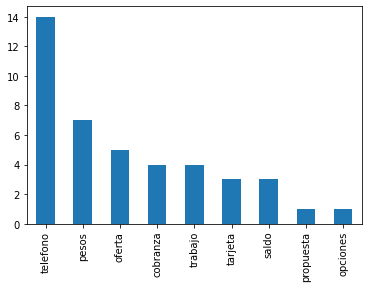

In [90]:
ax = df_dominant_topic['Dominant_Topic'].value_counts().plot(kind='bar')
plt.show()

The topis are almost balanced, so we are good

finally that we have our models set up, as well as analyzed, we can go
ahead to visualizing them.

In [59]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=f9b3b9dd7b3cc1ed3666e3e6320f008401f4a8980cafdd59d9cfce778851a304
  Stored in directory: /root/.cache/pip/wheels/90/61/ec/9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=67e81a883e15e95dcedc318d5c0bb4e8d1f4bd55063d6b8f55b873bf7b29bbac
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built pyLDAvis sklearn


In [60]:
import pyLDAvis

pyLDAvis.enable_notebook()

/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable


In [61]:
# %%time
import pyLDAvis.gensim_models as gensimvis
gensimvis.prepare(ldamodel, corpus, dictionary)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.054538 -0.037309       1        1  27.864937
7     -0.053694 -0.017627       2        1  18.093603
9     -0.056485 -0.042195       3        1  14.694282
2     -0.013300 -0.034998       4        1  14.201471
4     -0.038708 -0.033061       5        1   7.325431
5     -0.089775 -0.007806       6        1   6.203750
8     -0.008102  0.026293       7        1   3.268831
10    -0.002692  0.111447       8        1   3.190042
11     0.020209  0.125693       9        1   2.731935
1      0.141371 -0.048525      10        1   1.081056
3      0.056866 -0.027756      11        1   1.029566
6      0.098849 -0.014155      12        1   0.315098, topic_info=         Term        Freq       Total Category  logprob  loglift
53     semana  111.000000  111.000000  Default  30.0000  30.0000
1       deuda  257.000000  257.000000  Default  29.0000  29.0000
15       pago  359.000000  359.000000  Default  28.0000  28.0000
146     lunes   84.000000   84.000000  Default  27.0000  27.0000
9       saldo  102.000000  102.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
94       cosa    0.098507   43.964459  Topic12  -5.2187  -0.3410
15       pago    0.118943  359.015025  Topic12  -5.0302  -2.2524
17     cuotas    0.106633  118.616302  Topic12  -5.1394  -1.2542
9       saldo    0.103357  102.536128  Topic12  -5.1706  -1.1397
47   problema    0.099227   83.621419  Topic12  -5.2114  -0.9766

[697 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
62        1  0.099778   abogado
62        2  0.598667   abogado
62        6  0.199556   abogado
308       3  0.347541  abogados
308       6  0.347541  abogados
...     ...       ...       ...
361       7  0.217707  voluntad
131       1  0.559833       voz
131       2  0.279917       voz
348       2  0.350293    vuelta
348       3  0.350293    vuelta

[1324 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 8, 10, 3, 5, 6, 9, 11, 12, 2, 4, 7])

In [62]:
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,NaN,0.4750,"mente, registro, caso, saldo, domingo, financi...","[saldo, descuento, monto, posibilidad, monto, ..."
1,1,NaN,0.8356,"informe, periodo, total, metodo, referencia, e...","[nombre, datos, encargo, deposito, pago]"
2,2,NaN,0.5790,"mente, registro, caso, saldo, domingo, financi...","[saldo, pesos, descuento, saldo, pesos, posibi..."
3,3,NaN,0.3858,"validez, forma, casos, predisposicion, arreglo...","[manias, nombre, representante, motivo, motivo..."
4,4,NaN,0.3557,"bonificacion, acreditacion, contacto, pago, su...","[bonificacion, saldo, facilidad, situacion, se..."


In [96]:
df_news.longitud_turnos.unique()

array([ 75,  31,  86, 291, 308,  67, 439,  72,  81,  76, 374, 151, 139,
       249, 120,  79,  36,  40,  70,  89,  91, 143,  71, 221, 187, 103,
       263, 142, 152,  57, 112, 101,  74,  98,  39, 136, 109, 165,  88,
        35, 295,  55, 512,  63, 125,  37, 215,  47, 113, 134,  51,  95,
        44, 158, 222, 106, 160,  50, 102,  68,  78, 123,  60, 178, 137,
       130,  92, 185,  97, 188,  61,  90, 114, 133, 545,  49,  19,  26,
       104,  38, 144, 688,  43, 108,  56,  54,  66,  48,  82, 111,  28,
        87, 145,  34,  32, 141, 405,  41,  27,  83, 175,  53, 132, 157,
        45,  80, 169,  16,  85,  77,  22, 302, 107,  29, 372,  65,  30,
       312, 478, 262, 330,  69, 100, 122, 805, 201, 229, 226, 191,  25,
       138, 110, 172, 238])

In [92]:
df_news['labels'] =df_news['labels'].astype(str)

In [65]:
paggggos = df_news[df_news['labels'].str.contains('pago') == True]
datt = str(paggggos.transcripcion.to_list()).replace('[','').replace(']','').replace("'",'"')

In [66]:
paggggos.columns

Index(['Unnamed: 0', 'level_0', 'index', 'ID_MOPC', 'IDMOROSO', 'IDCLIENTE',
       'OPERADOR', 'CAMPAÑA', 'IDGRABACION', 'TIPO_DISCADOR', 'FECHA', 'ID',
       'IDLLAMADA', 'ESTADO', 'SUBESTADO', 'F_INICIO', 'ANI_TELEFONO',
       'GRABACION_DEP', 'TIPO', 'CRM', 'BASE', 'LOG', 'DIRECCION',
       'IDOPERADOR', 'AGENDAMIENTO_ESTADO', 'anos', 'mes',
       'transcripcion_limpia', 'Contestador', 'transcripcion', 'Valida',
       'turnos_tokenizados', 'turnos_filtrados', 'turnos_lematizados',
       'longitud_turnos', 'frases', 'sentimiento', 'transcripcion2', 'labels'],
      dtype='object')

In [67]:
paggggos.reset_index(inplace =True)

ValueError: ignored

In [68]:
paggggos

,Unnamed: 0,level_0,index,ID_MOPC,IDMOROSO,IDCLIENTE,OPERADOR,CAMPAÑA,IDGRABACION,TIPO_DISCADOR,...,transcripcion,Valida,turnos_tokenizados,turnos_filtrados,turnos_lematizados,longitud_turnos,frases,sentimiento,transcripcion2,labels


In [ ]:
print(paggggos.transcripcion2[0].replace(',','\n'))

In [ ]:
datt = list(datt.split(" "))

In [ ]:
datita = Counter(datt)
datita.most_common(15)

In [ ]:
most_common(datt)

In [93]:
len(df_dominant_topic), len(df_news)

(237, 238)

In [110]:
df_news.columns

Index(['Unnamed: 0', 'level_0', 'index', 'ID_MOPC', 'IDMOROSO', 'IDCLIENTE',
       'OPERADOR', 'CAMPAÑA', 'IDGRABACION', 'TIPO_DISCADOR', 'FECHA', 'ID',
       'IDLLAMADA', 'ESTADO', 'SUBESTADO', 'F_INICIO', 'ANI_TELEFONO',
       'GRABACION_DEP', 'TIPO', 'CRM', 'BASE', 'LOG', 'DIRECCION',
       'IDOPERADOR', 'AGENDAMIENTO_ESTADO', 'anos', 'mes',
       'transcripcion_limpia', 'Contestador', 'transcripcion', 'Valida',
       'turnos_tokenizados', 'turnos_filtrados', 'turnos_lematizados',
       'longitud_turnos', 'frases', 'sentimiento', 'transcripcion2', 'labels',
       'Keywords'],
      dtype='object')

In [103]:
df_news.AGENDAMIENTO_ESTADO.value_counts()

INTERESADO    171
COMPROMISO     67
Name: AGENDAMIENTO_ESTADO, dtype: int64

In [111]:
df_news.to_csv('df_final_1.csv')

In [109]:
df_news['Keywords'] = df_dominant_topic['Keywords']

In [106]:
compromiso = df_news[df_news['AGENDAMIENTO_ESTADO'].str.contains('COMPROMISO') == True]

In [108]:
compromiso.frases

5      ['buenas tardes se encuentra el senor alejandr...
6      ['buenas tardes ariel maximiliano merelaz dieg...
7      ['buenas tardes', 'y quiero hablar con maurici...
10     ['si bienvenida senora', 'pi', 'si senora moli...
12     ['disculpe hablo con el senor eduard eduardo m...
                             ...                        
221    ['ah si buen dia', 'veronica como te va la sen...
222    ['alvariz o con la encargada de los pagos de e...
224    ['buenas tardes con la senora', 'cristina cami...
232    ['buenas tardes con la senora coronel erika', ...
235    ['buenas dias el senor juan pablo vapalardo', ...
Name: frases, Length: 67, dtype: object

In [124]:
compromiso.frases.str.replace('[','').str.replace(']','').str.replace("'","").to_list()

<ipython-input-124-8f2953d3d6a3>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  compromiso.frases.str.replace('[','').str.replace(']','').str.replace("'","")


5      buenas tardes se encuentra el senor alejandro ...
6      buenas tardes ariel maximiliano merelaz diego ...
7      buenas tardes, y quiero hablar con mauricio pe...
10     si bienvenida senora, pi, si senora molina, si...
12     disculpe hablo con el senor eduard eduardo mar...
                             ...                        
221    ah si buen dia, veronica como te va la senora ...
222    alvariz o con la encargada de los pagos de ell...
224    buenas tardes con la senora, cristina camila s...
232    buenas tardes con la senora coronel erika, si ...
235    buenas dias el senor juan pablo vapalardo, si ...
Name: frases, Length: 67, dtype: object